In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_STATE = 42

X_blob, y_blob = make_blobs(n_samples=1000, 
                            centers=NUM_CLASSES, 
                            n_features=NUM_FEATURES, 
                            random_state=RANDOM_STATE)

In [3]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [5]:
X_val.dtype, y_val.dtype, X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(torch.float32,
 torch.float32,
 torch.float32,
 torch.float32,
 torch.float32,
 torch.float32)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
X_train = X_train.to(device=device)
y_train = y_train.to(device=device)
X_test = X_test.to(device=device)
y_test = y_test.to(device=device)
X_val = X_val.to(device=device)
y_val = y_val.to(device=device)

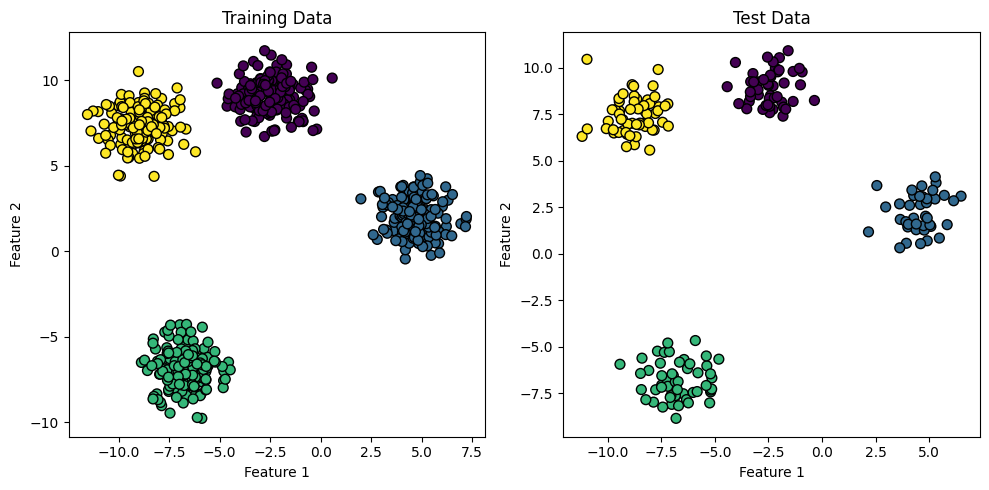

In [8]:
plt.figure(figsize=(10, 5))

# Plot training data
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=y_train.cpu(), cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot test data
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=y_test.cpu(), cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [9]:
class multi_class_classification(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [10]:
def accuracy(y_true ,y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [11]:
def train_and_evaluate(model_0,X_train, y_train, X_val, y_val, epochs=100, lr=0.01):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01, weight_decay=0.0001)


    for epoch in range(epochs):
        model_0.train()
        y_logits = model_0(X_train)
        Train_Acc = accuracy(y_true=y_train, y_pred=torch.argmax(torch.softmax(y_logits,dim=1), dim=1))
        optimizer.zero_grad()
        loss_train = loss_fn(y_logits, y_train.long())
        loss_train.backward()
        optimizer.step()

        model_0.eval()
        with torch.inference_mode():
            y_logits_val = model_0(X_val)
            loss_val = loss_fn(y_logits_val, y_val.long())
            Val_Acc = accuracy(y_true=y_val, y_pred=torch.argmax(torch.softmax(y_logits_val,dim=1), dim=1))
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss_train: .4f} | Validation Loss: {loss_val: .4f} | Train Accuracy: {Train_Acc} | Validation Accuracy: {Val_Acc}")

In [12]:
param_grid = {
    'hidden_units': [8, 16, 32],
    'lr': [0.001, 0.01, 0.1],
    'epochs': [50, 100, 200]
}

In [13]:
best_accuracy = 0
best_params = {}

In [14]:
for hidden_units in param_grid['hidden_units']:
    for lr in param_grid['lr']:
        for epochs in param_grid['epochs']:
            model_0 = multi_class_classification(input_features=2, output_features=4, hidden_units=hidden_units).to(device=device)
            next(model_0.parameters()).device
            print(f'Training with hidden_units={hidden_units}, lr={lr}, epochs={epochs}')
            train_and_evaluate(model_0, X_train, y_train, X_val, y_val, epochs=epochs, lr=lr)
            model_0.eval()
            with torch.inference_mode():
                val_outputs = model_0(X_val)
                val_accuracy = accuracy(y_true=y_val, y_pred=torch.argmax(torch.softmax(val_outputs,dim=1), dim=1))
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {'hidden_units': hidden_units, 'lr': lr, 'epochs': epochs}

print(f'Best Parameters: {best_params}')
print(f'Best Validation Accuracy: {best_accuracy:.4f}')

Training with hidden_units=8, lr=0.001, epochs=50
Epoch: 0 | Train Loss:  1.4291 | Validation Loss:  1.3521 | Train Accuracy: 23.75 | Validation Accuracy: 25.624999999999996
Epoch: 10 | Train Loss:  0.7708 | Validation Loss:  0.7146 | Train Accuracy: 99.84375 | Validation Accuracy: 99.375
Epoch: 20 | Train Loss:  0.2194 | Validation Loss:  0.2000 | Train Accuracy: 100.0 | Validation Accuracy: 99.375
Epoch: 30 | Train Loss:  0.0572 | Validation Loss:  0.0572 | Train Accuracy: 100.0 | Validation Accuracy: 99.375
Epoch: 40 | Train Loss:  0.0170 | Validation Loss:  0.0216 | Train Accuracy: 100.0 | Validation Accuracy: 99.375
Training with hidden_units=8, lr=0.001, epochs=100
Epoch: 0 | Train Loss:  1.4392 | Validation Loss:  1.3195 | Train Accuracy: 23.75 | Validation Accuracy: 26.875
Epoch: 10 | Train Loss:  0.7934 | Validation Loss:  0.7514 | Train Accuracy: 73.125 | Validation Accuracy: 76.25
Epoch: 20 | Train Loss:  0.4206 | Validation Loss:  0.3796 | Train Accuracy: 100.0 | Validation

In [15]:
# Initialize the model with the best parameters
best_model = multi_class_classification(input_features=2, 
                                        output_features=4, 
                                        hidden_units=best_params['hidden_units']).to(device)

# Train the model with the best parameters
train_and_evaluate(best_model, X_train, y_train, X_val, y_val, 
                   epochs=best_params['epochs'], lr=best_params['lr'])

# Evaluate the model on the test data
best_model.eval()
with torch.inference_mode():
    y_pred_test = best_model(X_test)
    test_loss = nn.CrossEntropyLoss()(y_pred_test, y_test.long())
    test_accuracy = accuracy(y_true=y_test, y_pred=torch.argmax(torch.softmax(y_pred_test,dim=1), dim=1))

print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch: 0 | Train Loss:  2.0207 | Validation Loss:  1.7399 | Train Accuracy: 0.0 | Validation Accuracy: 0.0
Epoch: 10 | Train Loss:  0.9447 | Validation Loss:  0.9237 | Train Accuracy: 39.0625 | Validation Accuracy: 63.125
Epoch: 20 | Train Loss:  0.5806 | Validation Loss:  0.5499 | Train Accuracy: 78.28125 | Validation Accuracy: 83.75
Epoch: 30 | Train Loss:  0.2968 | Validation Loss:  0.2896 | Train Accuracy: 99.84375 | Validation Accuracy: 100.0
Epoch: 40 | Train Loss:  0.1223 | Validation Loss:  0.1209 | Train Accuracy: 100.0 | Validation Accuracy: 99.375
Epoch: 50 | Train Loss:  0.0439 | Validation Loss:  0.0478 | Train Accuracy: 100.0 | Validation Accuracy: 99.375
Epoch: 60 | Train Loss:  0.0205 | Validation Loss:  0.0255 | Train Accuracy: 100.0 | Validation Accuracy: 99.375
Epoch: 70 | Train Loss:  0.0125 | Validation Loss:  0.0175 | Train Accuracy: 100.0 | Validation Accuracy: 99.375
Epoch: 80 | Train Loss:  0.0090 | Validation Loss:  0.0146 | Train Accuracy: 100.0 | Validation 

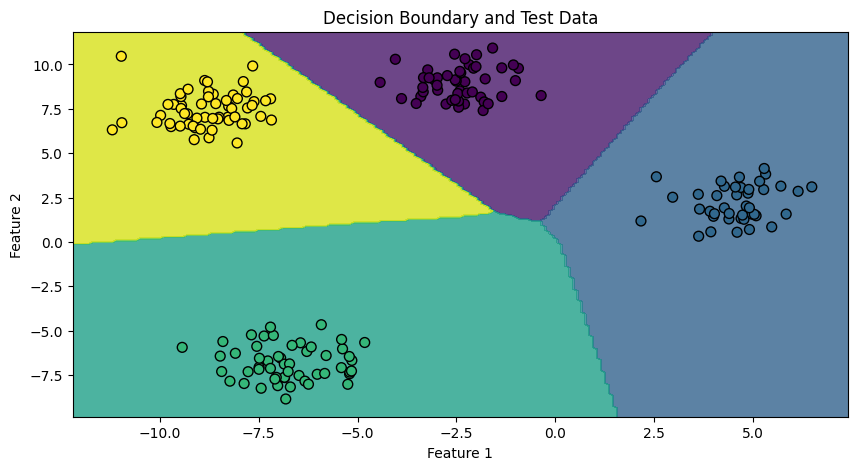

In [16]:
import numpy as np

# Create a mesh grid
x_min, x_max = X_test[:, 0].min().cpu() - 1, X_test[:, 0].max().cpu() + 1
y_min, y_max = X_test[:, 1].min().cpu() - 1, X_test[:, 1].max().cpu() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Flatten the grid to pass through the model
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float).to(device)

# Get model predictions for each point in the grid
with torch.no_grad():
    Z = best_model(grid)
    Z = torch.argmax(Z, dim=1).cpu().numpy()

# Reshape the predictions back to the mesh grid shape
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 5))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')

# Plot the test data points
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=y_test.cpu(), edgecolor='k', marker='o', s=50, cmap='viridis')
plt.title('Decision Boundary and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [17]:
import os
os.makedirs(r"C:\Users\Ahmad\Desktop\Project\Pytorch\Pytorch Workflow\Classification", exist_ok=True)
torch.save(obj=model_0.state_dict(), f=r"C:\Users\Ahmad\Desktop\Project\Pytorch\Pytorch Workflow\Classification\model_Classification_MultiClass_state_dict.pth")
